In [32]:
import numpy as np
from nptyping import NDArray
import random
import numpy.linalg as LA
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple, Optional, Any, Callable
from utils import load_image_to_arr, display_rgb, SVD2D
import dim_reduction
from spectral_data import ImageSpectralData
dim_reduction.init_basis_cache()

(540, 960, 3)


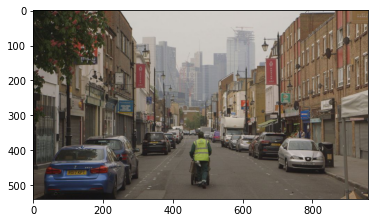

In [34]:
PONOS = load_image_to_arr("street.jpg")
print(PONOS.shape)
display_rgb(PONOS)

In [35]:
class ImageAtScale:
    def __init__(self, imageChunk: NDArray[Any], anchor: Tuple[int, int]):
        self.imageChunk: NDArray[Any] = imageChunk
        self.imageSize: int = imageChunk.shape[0]
        self.anchor: Tuple[int, int] = anchor
        self.chunk_spectral_data: ImageSpectralData = None

    def compute_spectral_data(self):
        if(self.chunk_spectral_data is None):
            self.chunk_spectral_data = ImageSpectralData(self.imageChunk)
        return self.chunk_spectral_data

class ImageChunkAttributeSummarizer:
    def __init__(self, chunks: List[ImageAtScale], attribute_size: int, is_metadata: bool, description: str = "no summary", id: str = "ID"):
        self.description: str = description
        self.chunks: List[ImageAtScale] = chunks
        self.n_chunks: int = len(chunks)
        self.attribute_size = attribute_size
        self.is_metadata = is_metadata
        self.summary: NDArray[Any] = np.zeros((self.n_chunks, self.attribute_size))
        self.feature_id: str = id

    def calculate_summary(self) -> NDArray[Any]:
        pass


class ImageChunkMeanSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale]):
        description = "Image Chunk RGB Mean"
        summary_id = "mean"
        super().__init__(chunks, 3, False, description, summary_id)

    def calculate_summary(self):
        for i in range(self.n_chunks):
            spec_data = self.chunks[i].compute_spectral_data()
            self.summary[i] = spec_data.mean_color

class ImageChunkPrincipleColorLengthSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], principle_color_index: int):
        description = f"The length of principle color {principle_color_index}"
        summary_id = f"pc_{principle_color_index}_len"
        super().__init__(chunks, 1, True, description, summary_id)
        self.principle_color_index = principle_color_index

    def calculate_summary(self) -> NDArray[Any]:
        for i in range(self.n_chunks):
            spec_data = self.chunks[i].compute_spectral_data()
            self.summary[i, 0] = spec_data.pc_lengths[self.principle_color_index]

class ImageChunkPrincipleColorSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], principle_color_index: int) -> None:
        description = f"Priciple color {principle_color_index}"
        summary_id = f"pc_{principle_color_index}"
        super().__init__(chunks, 3, True, description, summary_id)
        self.principle_color_index = principle_color_index

    def calculate_summary(self) -> NDArray[Any]:
        for i in range(self.n_chunks):
            spec_data = self.chunks[i].compute_spectral_data()
            self.summary[i, :] = spec_data.principle_colors[self.principle_color_index]

class ImageChunkPCACoeffSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale], pc_index: int, n_coeffs: int):
        desc = f"{n_coeffs} PCA coefficients of this image chunks's {pc_index}th principle color channel"
        summary_id = f"pcm_{pc_index}_PCA_coeffs"
        super().__init__(chunks, n_coeffs, True, desc, summary_id)
        self.pc_index: int = pc_index
        self.n_coeffs: int = n_coeffs

    def calculate_summary(self) -> NDArray[Any]:
        for i in range(self.n_chunks):
            spec_data = self.chunks[i].compute_spectral_data()
            B, coeff = spec_data.get_pcm_pca_coeffs(self.pc_index, self.n_coeffs)
            self.summary[i, :] = coeff

class ImageChunkAnchorSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale]) -> None:
        desc = "Top-Left Coordinate of Chunk"
        summary_id = "anchor"
        super().__init__(chunks, 2, True, desc, summary_id)
    
    def calculate_summary(self):
        for i in range(self.n_chunks):
            self.summary[i, 0] = self.chunks[i].anchor[0]
            self.summary[i, 1] = self.chunks[i].anchor[1]

class ImageChunkCenterLocationSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale]) -> None:
        desc = "Center Coordinate of Chunk"
        summary_id = "center_loc"
        super().__init__(chunks, 2, False, desc, summary_id)
    
    def calculate_summary(self):
        center_offset = self.chunks[0].imageSize / 2
        for i in range(self.n_chunks):
            self.summary[i, 0] = self.chunks[i].anchor[0] + center_offset
            self.summary[i, 1] = self.chunks[i].anchor[1] + center_offset

class ImageChunkSizeSummarizer(ImageChunkAttributeSummarizer):
    def __init__(self, chunks: List[ImageAtScale]) -> None:
        desc = "1D size of chunk"
        summary_id = "size1D"
        super().__init__(chunks, 1, False, desc, summary_id)

    def calculate_summary(self):
        size = self.chunks[0].imageSize
        self.summary[:, :] = size

class MultiScaleImageChunkSummarizer:
    def __init__(self):
        pass

class ImageChunkSummarizerOptions:
    def __init__(self) -> None:
        self.include_mean = True
        self.included_principle_colors = [True, True, True]
        self.include_center = True
        self.include_anchor = True
        self.n_pcm_coeffs = [20, 5, 3]


class ImageChunkEncoder:
    def __init__(self, options: ImageChunkSummarizerOptions):
        self.options: ImageChunkSummarizerOptions = options
        self.summarizers: List[ImageChunkAttributeSummarizer] = []
        self.feature_masks: Dict[str, NDArray[Any]] = {}
        self.num_total_features: int = -1
        
    def setup_summaries(self, chunks: List[ImageAtScale]):
        options = self.options
        n_chunk_summary_features = 0
        summarizers: List[ImageChunkAttributeSummarizer] = []
        summarizers.append(ImageChunkSizeSummarizer(chunks))
        if(options.include_mean):
            summarizers.append(ImageChunkMeanSummarizer(chunks))
        for pci in range(3):
            if(options.included_principle_colors[pci]):
                summarizers.append(ImageChunkPrincipleColorLengthSummarizer(chunks, pci))
                summarizers.append(ImageChunkPrincipleColorSummarizer(chunks, pci))
                summarizers.append(ImageChunkPCACoeffSummarizer(chunks, pci, options.n_pcm_coeffs[pci]))
        if(options.include_center):
            summarizers.append(ImageChunkCenterLocationSummarizer(chunks))
        if(options.include_anchor):
            summarizers.append(ImageChunkAnchorSummarizer(chunks))
        
        self.num_total_features = sum([s.attribute_size for s in summarizers])
        feature_index = 0
        for summarizer in summarizers:
            attr_size = summarizer.attribute_size
            self.feature_masks[summarizer.feature_id] = np.zeros(self.num_total_features, dtype=bool)
            self.feature_masks[summarizer.feature_id][feature_index:feature_index + attr_size] = True
            feature_index += attr_size

        self.summarizers = summarizers

    def encode_summaries(self, chunks: List[ImageAtScale]):
        result = np.zeros((len(chunks), self.num_total_features))
        for summarizer in self.summarizers:
            summarizer.calculate_summary()
            feature_mask = self.feature_masks[summarizer.feature_id]
            result[:, feature_mask] = summarizer.summary
        return result

class ImageChunkDecoder:
    def __init__(self, image_feature_masks: NDArray[Any]) -> None:
        self.feature_masks = image_feature_masks


    def decode_no_location(self, feature_vec: NDArray[Any]):
        dim1D =  int(feature_vec[self.feature_masks["size1D"]][0])
        empty_spec_data = ImageSpectralData(None, dim1D)
        empty_spec_data.dim1D = dim1D
        empty_spec_data.mean_color = feature_vec[self.feature_masks["mean"]]
        for pci in range(3):
            pcID = f"pc_{pci}"
            pclenID = f"pc_{pci}_len"
            pcCoeffID = f"pcm_{pci}_PCA_coeffs"
            if(pcID in self.feature_masks):
                empty_spec_data.principle_colors[pci] = feature_vec[self.feature_masks[pcID]]
            if(pclenID in self.feature_masks):
                empty_spec_data.pc_lengths[pci] = feature_vec[self.feature_masks[pclenID]]
            if(pcCoeffID in self.feature_masks):
                coeffs = feature_vec[self.feature_masks[pcCoeffID]]
                B = dim_reduction.get_basis(dim1D)
                pcm = B.get_approximation_from_coeffs(coeffs).reshape((dim1D, dim1D))
                empty_spec_data.PCMs[pci] = pcm
        return empty_spec_data.get_realization()
        
        


class MultiScaleImageSampler:
    def __init__(self, scales: List[int]) -> None:
        #pre-condition: All scales are even numbers.
        self.scales: List[int] = scales
        self.num_scales: int = len(scales)
        self.first_scale = scales[0]

    def sample(self, image: NDArray[Any]) -> List[ImageAtScale]:
        imgY = image.shape[0]
        imgX = image.shape[1]
        anchors: List[Tuple[int, int]] = []
        result: List[ImageAtScale] = []
        
        first_anchor_X = random.randint(0, imgX - self.first_scale)
        first_anchor_Y = random.randint(0, imgY - self.first_scale)
        anchors.append((first_anchor_X, first_anchor_Y))

        for i in range(1, self.num_scales):
            prev_anchor_x, prev_anchor_y = anchors[i-1]
            prev_scale = self.scales[i-1]
            scale = self.scales[i]
            anchor_x = prev_anchor_x + ((prev_scale - scale) // 2)
            anchor_y = prev_anchor_y + ((prev_scale - scale) // 2)
            anchors.append((anchor_x, anchor_y))
    
        for i in range(self.num_scales):
            anchor_x, anchor_y = anchors[i]
            scale = self.scales[i]
            chunk = image[anchor_y:anchor_y+scale, anchor_x:anchor_x+scale, :]
            result.append(ImageAtScale(chunk, anchors[i]))
        
        return result
        

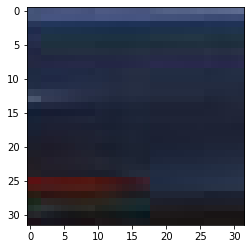

In [53]:
sampler = MultiScaleImageSampler([32])
scales = sampler.sample(PONOS)
display_rgb(scales[0].imageChunk)
#display_rgb(scales[1].imageChunk)
#display_rgb(scales[2].imageChunk)

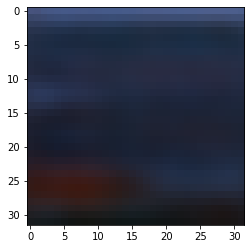

In [57]:
chunk_summarizer_options = ImageChunkSummarizerOptions()
chunk_summarizer_options.n_pcm_coeffs = [100, 30, 20]
chunk_encoder = ImageChunkEncoder(chunk_summarizer_options)
chunk_encoder.setup_summaries([scales[0]])

S = chunk_encoder.encode_summaries([scales[0]])
decoder = ImageChunkDecoder(chunk_encoder.feature_masks)
I = decoder.decode_no_location(S[0])
display_rgb(I)

In [6]:
import spectral_data

In [2]:
D = spectral_data.ImageSpectralData(scales[1].imageChunk)
pcm1 = D.PCMs[0]
fig, ax = plt.subplots()
ax.imshow(pcm1)

NameError: name 'spectral_data' is not defined

In [30]:
pcm1_flat = pcm1.ravel()
pca_basis = dim_reduction.get_basis(64)
coeffs = pca_basis.get_basis_coeffs(pcm1_flat, 255)
print(coeffs.shape)
pcm1_approx = pca_basis.get_approximation_from_coeffs(coeffs).reshape((128, 128))
fig, ax = plt.subplots()
ax.imshow(pcm1_approx)

ValueError: shapes (4096,) and (16384,255) not aligned: 4096 (dim 0) != 16384 (dim 0)

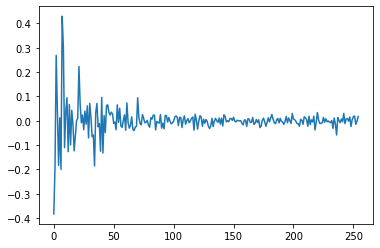

In [29]:
fig, ax = plt.subplots()
ax.plot(coeffs)